In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings("ignore")

# 🔽 Load Dataset

In [4]:
df = pd.read_csv('Train.csv')

In [5]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


# 🔍 Data Cleaning and Preprocessing


In [7]:
# Drop Uneccessary columns (ID)
if 'ID' in df.columns:
  df =df.drop(columns=['ID'])

In [8]:
# Encode categorical Values
cat_cols = df.select_dtypes(include = 'object').columns
le = LabelEncoder()
for col in cat_cols:
  df[col] = le.fit_transform(df[col])

# Rename target column
df.rename(columns={'Reached.on.Time_Y.N': 'Late_delivery_risk'}, inplace=True)

# 📊 EDA and Visualizations

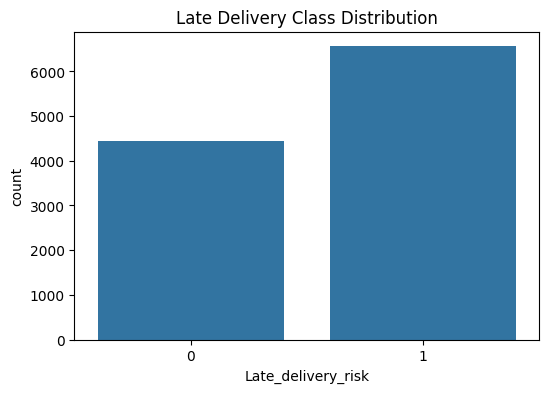

In [9]:
plt. figure(figsize=(6, 4))
sns.countplot(x ='Late_delivery_risk', data =df)
plt.title('Late Delivery Class Distribution')
plt.show()

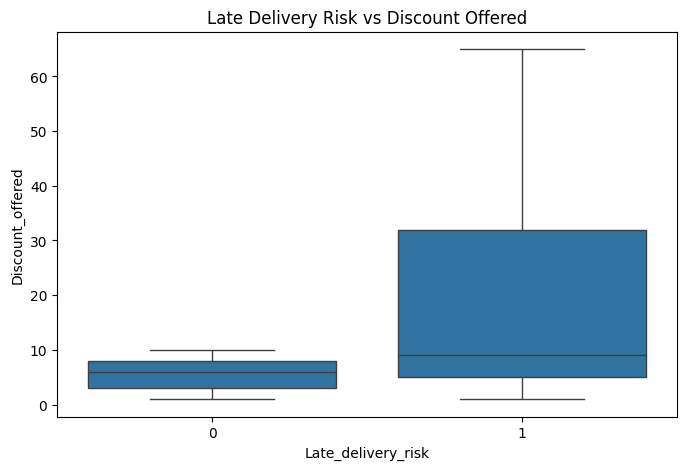

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(x ='Late_delivery_risk', y ='Discount_offered', data = df)
plt.title('Late Delivery Risk vs Discount Offered')
plt.show()

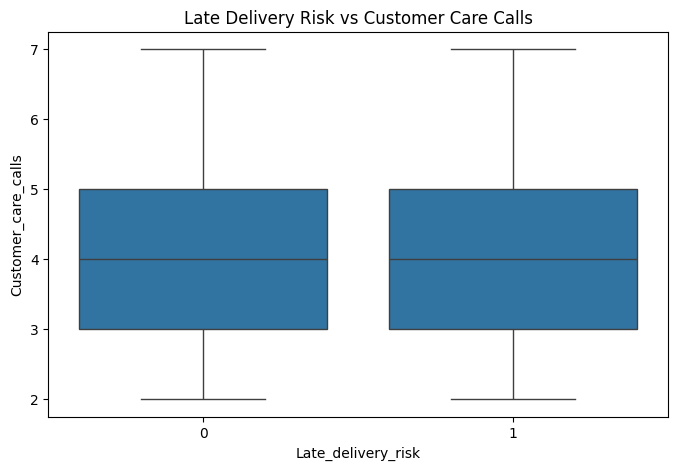

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(x ='Late_delivery_risk', y ='Customer_care_calls', data = df)
plt.title('Late Delivery Risk vs Customer Care Calls')
plt.show()

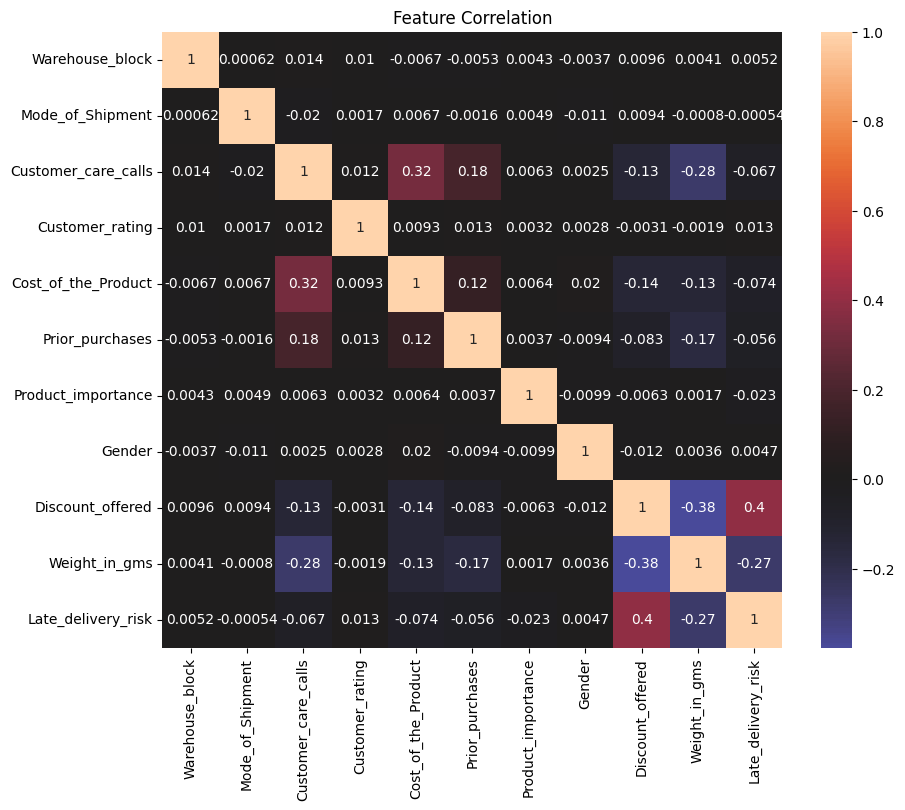

In [12]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, center = 0)
plt.title('Feature Correlation')
plt.show()

# Key EDA Insights:

### - Higher discounts correlate with delayed deliveries
### - More customer calls often indicate issues with delivery
### - Product importance and shipping mode also affect delay risk

# Feature/Target Split & Scaling

In [13]:
X = df.drop('Late_delivery_risk', axis =1)
y =df['Late_delivery_risk']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Logistic Regression (for Interpretability)

In [15]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log =log_model.predict(X_test)

print("\n Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_pred_log))


 Logistic Regression Results:
[[1093  228]
 [ 603  702]]
              precision    recall  f1-score   support

           0       0.64      0.83      0.72      1321
           1       0.75      0.54      0.63      1305

    accuracy                           0.68      2626
   macro avg       0.70      0.68      0.68      2626
weighted avg       0.70      0.68      0.68      2626

Accuracy: 0.6835491241431836
Accuracy: 0.6835491241431836
ROC AUC: 0.6826672583466026


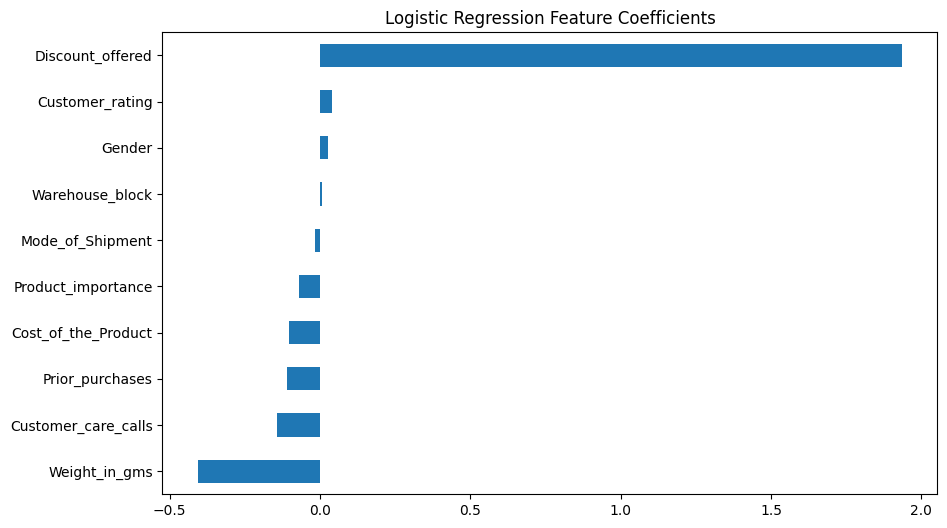

In [16]:
# Coefficient Plot
plt.figure(figsize=(10, 6))
coeff_df = pd.Series(log_model.coef_[0], index=X.columns)
coeff_df.sort_values().plot(kind='barh')
plt.title('Logistic Regression Feature Coefficients')
plt.show()

# XGBoost Model (for Prediction)

In [17]:
xgb_base = xgb.XGBClassifier(eval_metric='logloss')
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(xgb_base, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid.fit(X_train, y_train)

xgb_model = grid.best_estimator_
y_pred_xgb = xgb_model.predict(X_test)

print("\n📈 XGBoost Results (Tuned):")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_pred_xgb))

Fitting 3 folds for each of 16 candidates, totalling 48 fits

📈 XGBoost Results (Tuned):
[[1119  202]
 [ 510  795]]
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      1321
           1       0.80      0.61      0.69      1305

    accuracy                           0.73      2626
   macro avg       0.74      0.73      0.72      2626
weighted avg       0.74      0.73      0.72      2626

Accuracy: 0.7288651942117289
ROC AUC: 0.7281404717777372


# Feature Importance

<Figure size 1000x600 with 0 Axes>

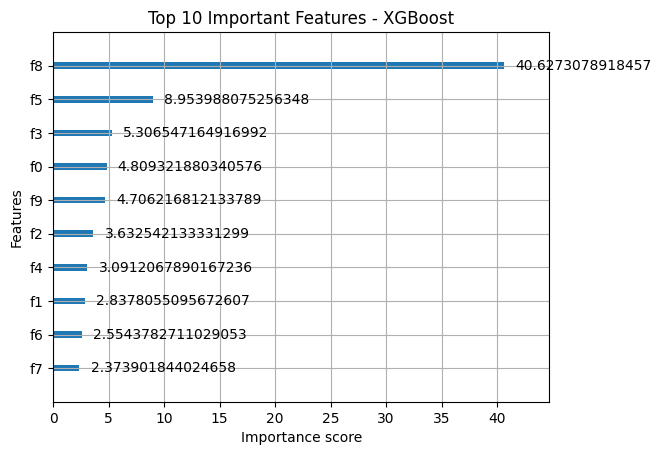

In [18]:
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features - XGBoost")
plt.show()

# SHAP Interpretability

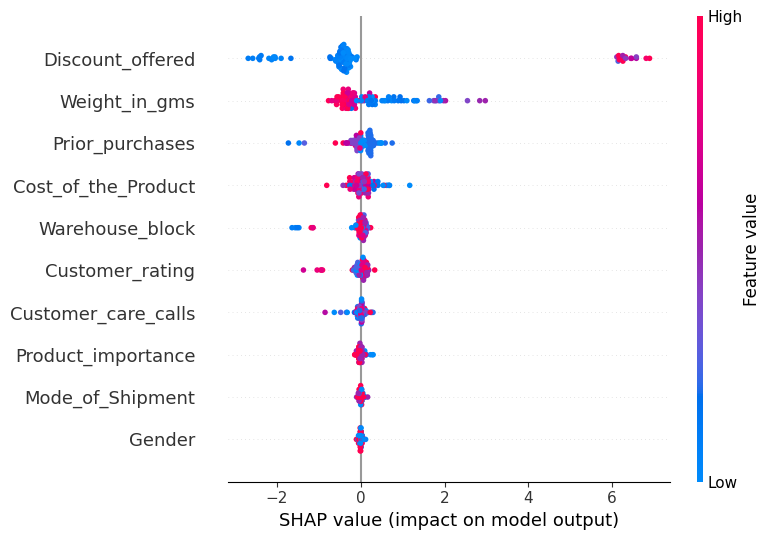

In [20]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train_df[:100])
shap.summary_plot(shap_values, X_train_df[:100])

# Recommendations

### 1. Prioritize important products for faster shipping.
### 2. Adjust shipping mode based on distance and product value.
### 3. Use real-time risk scoring for order prioritization.
### 4. Reduce discounts offered for low-priority orders to prevent abuse.
### 5. Monitor and reduce high volumes of customer complaints linked to delays.
### 6. Use SHAP insights to build explainable models for stakeholders.
